<a href="https://colab.research.google.com/github/juurie/Projects/blob/main/%EC%9D%8C%ED%96%A5%EB%B6%84%EB%A5%98%20%EB%94%A5%EB%9F%AC%EB%8B%9D%EC%9D%84%20%ED%99%9C%EC%9A%A9%ED%95%9C%20%EC%9D%8C%EC%84%B1%ED%92%88%EC%A7%88%20%EA%B3%A0%EB%8F%84%ED%99%94%20%EA%B8%B0%EC%88%A0(TFLite_v8_sound_flag_hub_v1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
flag_colab = 1
flag_hub = 0
if flag_colab == 1:
    from google.colab import drive
    drive.mount('/content/gdrive/')
    path_root = '/content/gdrive/MyDrive/proj/dataset_img'
    
    # !pip install h5py==2.10.0
    # !pip install tensorflow_hub
else:
    path_root = 'c:/proj/soundsep/dataset_img_224'

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd

In [ ]:
print("Version: ", tf.__version__)
#print("Hub version: ", hub.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  2.9.2
Eager mode:  True
GPU is available


### Dataset preparation

In [ ]:
# Learn more about data batches
#Image batch shape:  (32, 224, 224, 3)
#Label batch shape:  (32, 5)

In [ ]:
folder_list = os.listdir(path_root)
print('folder_list',folder_list)
num_classes = len(folder_list)
print('num_classes', num_classes)

folder_list ['white_noise', 'howling', 'car_noise', 'babbling', 'voice']
num_classes 5


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Create data generator for training and validation

IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(path_root)

datagen_kwargs = dict(rescale=1./255, validation_split=.20)

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="validation", 
    shuffle=True,
    target_size=IMAGE_SHAPE
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="training", 
    shuffle=True,
    target_size=IMAGE_SHAPE)

Found 806 images belonging to 5 classes.
Found 3224 images belonging to 5 classes.


In [ ]:
# Learn more about data batches

image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [ ]:
# Learn about dataset labels

dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Babbling' 'Car_Noise' 'Howling' 'Voice' 'White_Noise']


In [ ]:
# Get images and labels batch from validation dataset generator

val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)

print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


### Model architecture, training

As a base model for transfer learning, we'll use MobileNet v2 model stored on TensorFlow Hub. Presented model can be used only in TensorFlow 2.0 implementation (TF Hub contains also models for TensorFlow 1.x).

Basic information about feature vector:
- Input shape: 224x224x3 (224x224 pixels, 3 chanels each, RGB format),
- Each channel has value in range [0, 1],
- Feature vector output shape: 1280 (number of labels classified by MobileNet is 1001 - this info isn't important here)

For more details check feature vector page:
https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4

In [ ]:
if flag_hub == 1:
    base_model = hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4", 
                 output_shape=[1280],
                 trainable=False)
else:    
    from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
    base_model = MobileNetV2(
        input_shape=(224, 224, 3),
        alpha=0.35,
        include_top=False,
        weights='imagenet',
        input_tensor=None,
        pooling=None,
        classes=num_classes,
        classifier_activation='softmax'
    )
    base_model.trainable = False


2019640/2019640 [==============================] - 0s 0us/step


In [ ]:
rate_dropout = 0.2

In [ ]:
model = tf.keras.Sequential()
model.add(base_model)

if flag_hub == 0:
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    
model.add(tf.keras.layers.Dropout(rate_dropout))

model.add(tf.keras.layers.Dense(360, activation='relu'))
model.add(tf.keras.layers.Dropout(rate_dropout))
model.add(tf.keras.layers.Dense(180, activation='relu'))
model.add(tf.keras.layers.Dropout(rate_dropout))
model.add(tf.keras.layers.Dense(30, activation='relu'))
model.add(tf.keras.layers.Dropout(rate_dropout))

model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(
        train_generator,
        steps_per_epoch=10,
        epochs=10,
        validation_data=valid_generator,
        validation_steps=10)

Epoch 1/10
10/10 [==============================] - 131s 13s/step - loss: 1.5758 - accuracy: 0.3406 - val_loss: 1.2219 - val_accuracy: 0.5219
Epoch 2/10
10/10 [==============================] - 93s 10s/step - loss: 1.2037 - accuracy: 0.4875 - val_loss: 1.0199 - val_accuracy: 0.5312
Epoch 3/10
10/10 [==============================] - 76s 8s/step - loss: 1.0139 - accuracy: 0.5688 - val_loss: 1.0067 - val_accuracy: 0.6281
Epoch 4/10
10/10 [==============================] - 60s 6s/step - loss: 0.9089 - accuracy: 0.6125 - val_loss: 0.9078 - val_accuracy: 0.5656
Epoch 5/10
10/10 [==============================] - 43s 4s/step - loss: 0.9005 - accuracy: 0.6218 - val_loss: 0.8370 - val_accuracy: 0.6656
Epoch 6/10
10/10 [==============================] - 39s 4s/step - loss: 0.7207 - accuracy: 0.7219 - val_loss: 0.7649 - val_accuracy: 0.6938
Epoch 7/10
10/10 [==============================] - 35s 3s/step - loss: 0.7015 - accuracy: 0.7000 - val_loss: 0.8252 - val_accuracy: 0.7188
Epoch 8/10
10/10 

model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

# Run model training

hist = model.fit(feature_train, label_train, validation_split = 0.3, epochs=20, verbose=1).history

In [ ]:
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [ ]:
image_w = 224
image_h = 224
data_feature = []
data_label = []
idx_plot = 0
for index in range(len(folder_list)):
    path_file = os.path.join(path_root, folder_list[index])
    
    img_list = os.listdir(path_file)
    for img in img_list:
        
        img_path = os.path.join(path_file, img)
        '''img = cv2.cv2.imread(img_path, cv2.IMREAD_COLOR)'''
        img = cv2.imread(img_path) #, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, None, fx=image_w/img.shape[1], fy=image_h/img.shape[0])
        # 1) standardize or
        img = tf.image.per_image_standardization(img)
        data_feature.append(img)
        # 2) standardize 
        data_label.append(index)
        

In [ ]:
num_color = 3
data_feature = tf.reshape(data_feature, [-1, image_w, image_h, num_color]) 
print('np.shape(data_feature)', np.shape(data_feature))

np.shape(data_feature) (4030, 224, 224, 3)


In [ ]:
data_label = to_categorical(data_label, num_classes)

In [ ]:
data_feature = np.array(data_feature)
data_label = np.array(data_label)

In [ ]:
from sklearn.model_selection import train_test_split
feature_train, feature_test, label_train, label_test = train_test_split(data_feature,data_label)
print('label_train',label_train)

label_train [[0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]


In [ ]:
hist = model.fit(feature_train, label_train, validation_split = 0.3, epochs=20, verbose=1).history

Epoch 1/20
67/67 [==============================] - 7s 64ms/step - loss: 1.2556 - acc: 0.5305 - val_loss: 0.6798 - val_acc: 0.6957
Epoch 2/20
67/67 [==============================] - 3s 38ms/step - loss: 0.6278 - acc: 0.7584 - val_loss: 0.3517 - val_acc: 0.9107
Epoch 3/20
67/67 [==============================] - 3s 38ms/step - loss: 0.4083 - acc: 0.8511 - val_loss: 0.2570 - val_acc: 0.9184
Epoch 4/20
67/67 [==============================] - 2s 37ms/step - loss: 0.3469 - acc: 0.8785 - val_loss: 0.2718 - val_acc: 0.9052
Epoch 5/20
67/67 [==============================] - 3s 37ms/step - loss: 0.2874 - acc: 0.9035 - val_loss: 0.1735 - val_acc: 0.9394
Epoch 6/20
67/67 [==============================] - 2s 37ms/step - loss: 0.2269 - acc: 0.9229 - val_loss: 0.1645 - val_acc: 0.9272
Epoch 7/20
67/67 [==============================] - 2s 37ms/step - loss: 0.1973 - acc: 0.9338 - val_loss: 0.1901 - val_acc: 0.9361
Epoch 8/20
67/67 [==============================] - 2s 37ms/step - loss: 0.2163 - a

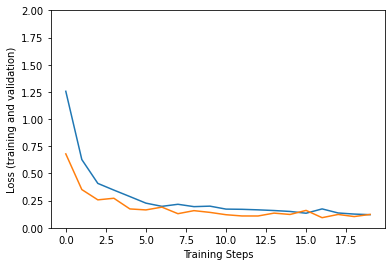

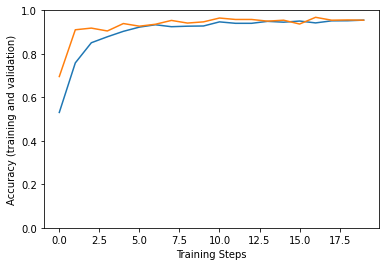

In [ ]:
# Visualize training process

plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])

# Measure accuracy and loss after training

final_loss, final_accuracy = model.evaluate(feature_test, label_test)

In [ ]:
final_loss, final_accuracy = model.evaluate(feature_test, label_test)

32/32 [==============================] - 1s 33ms/step - loss: 0.1215 - acc: 0.9603


#print(feature_test)
print(np.unique(feature_test))

print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

In [ ]:
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

Final loss: 0.12
Final accuracy: 96.03%


In [ ]:
final_loss, final_accuracy = model.evaluate(feature_test, label_test)

In [ ]:
SOUNDSEP_SAVED_MODEL = './model'
tf.saved_model.save(model, SOUNDSEP_SAVED_MODEL)

In [ ]:
# Load SavedModel
soundsep_model = tf.saved_model.load(SOUNDSEP_SAVED_MODEL)

#soundsep_model = hub.load(SOUNDSEP_SAVED_MODEL)
print(soundsep_model)

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f5909205810>


In [ ]:
# TF Lite 특징

# 모델 사이즈를 줄이기 위한 Quantization 등과 같은 모델 최적화를 위한 툴을 제공함
# 이러한 툴들은 모델 사이즈를 줄이고, 속도를 향상시키면서 정확도의 손실은 최소화함

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Create data generator for training and validation

datagen_kwargs = dict(rescale=1./255, validation_split=.20)

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="validation", 
    shuffle=True,
    target_size=IMAGE_SHAPE
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="training", 
    shuffle=True,
    target_size=IMAGE_SHAPE)

Found 102 images belonging to 5 classes.
Found 410 images belonging to 5 classes.


In [ ]:
# Learn more about data batches

image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [ ]:
# Learn about dataset labels

dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Babbling' 'Car_Noise' 'Howling' 'Voice' 'White_Noise']


In [ ]:
# Get images and labels batch from validation dataset generator

val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)

print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [ ]:
tf_model_predictions = soundsep_model(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

Prediction results shape: (32, 5)


In [ ]:
# Convert prediction results to Pandas dataframe, for better visualization

tf_pred_dataframe = pd.DataFrame(tf_model_predictions.numpy())
tf_pred_dataframe.columns = dataset_labels

print("Prediction results for the first elements")
tf_pred_dataframe

Prediction results for the first elements


,Babbling,Car_Noise,Howling,Voice,White_Noise
0,1.212265e-02,7.179413e-03,6.533393e-03,9.734324e-01,7.320769e-04
1,1.209698e-02,9.876166e-01,5.396679e-05,2.174540e-04,1.504380e-05
2,1.203937e-02,7.603034e-05,9.869733e-01,8.996647e-04,1.149354e-05
3,3.945529e-02,4.297205e-02,4.045797e-02,8.759639e-01,1.150741e-03
4,2.023221e-01,4.111238e-02,4.539298e-02,7.070721e-01,4.100415e-03
5,4.554911e-08,4.532346e-11,9.943320e-08,3.067640e-07,9.999995e-01
6,9.998234e-01,3.713609e-05,1.370854e-04,2.245645e-06,8.367952e-08
7,1.590903e-02,1.238344e-04,9.816946e-01,2.257961e-03,1.467174e-05
8,3.389735e-02,1.007270e-02,4.382643e-02,9.095734e-01,2.630183e-03
9,4.187141e-05,1.792954e-06,5.262272e-06,8.121204e-05,9.998698e-01


In [ ]:
tf_model_predictions[0]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([1.2122652e-02, 7.1794130e-03, 6.5333927e-03, 9.7343236e-01,
       7.3207694e-04], dtype=float32)>

In [ ]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]

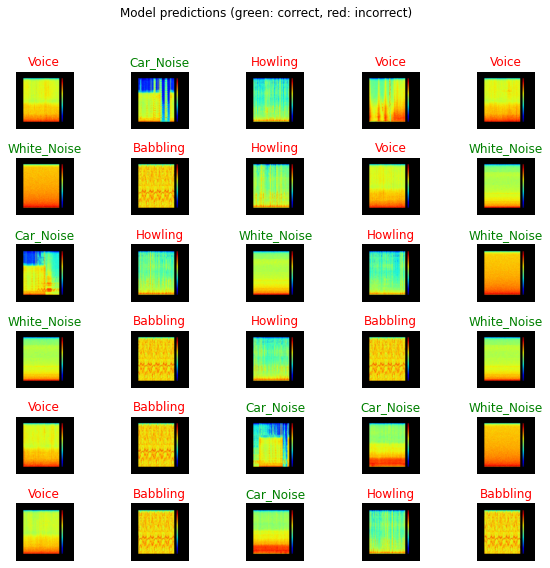

In [ ]:
# Print images batch and labels predictions

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

## Convert model to TFLite

Convert recently loaded model to TensorFlow Lite models (standard and quantized with a [post-training quantization](https://www.tensorflow.org/lite/performance/post_training_quantization)).

Because of TensorFlow 2.0 nature, we'll need to convert TensorFlow model into concrete function and then do conversion to TFLite. More about it [here](https://www.tensorflow.org/lite/r2/convert/concrete_function).

!mkdir "tflite_models"

In [ ]:
!mkdir "tflite_models"

In [ ]:
TFLITE_MODEL = "tflite_models/soundsep.tflite" 
TFLITE_QUANT_MODEL = "tflite_models/soundsep_quant.tflite"

In [ ]:
# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : soundsep_model(x)) ## Keras 모델에서 구체적인 함수를 가져옴

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

# Convert the model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

# Convert the model to quantized version with post-training quantization
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func]) ## 훈련 후 양자화를 통해 모델을 양자화 버전으로 변환
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_quant_model = converter.convert()
open(TFLITE_QUANT_MODEL, "wb").write(tflite_quant_model)

print("TFLite models and their sizes:")
# !ls "tflite_models" -lh  # 리눅스에서만 가능

TFLite models and their sizes:


### Load TFLite model

Load TensorFlow lite model with interpreter interface.

# Load TFLite model and see some details about input/output

tflite_interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL)

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

In [ ]:
# Load TFLite model and see some details about input/output

tflite_interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL) ## TFLite 모델 로드

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape']) ## 32로 되어야함
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape']) ## 32로 되어야함
print("type:", output_details[0]['dtype'])

== Input details ==
name: x
shape: [  1 224 224   3]
type: <class 'numpy.float32'>

== Output details ==
name: Identity
shape: [1 5]
type: <class 'numpy.float32'>


#### Resize input and output tensors shapes

Input shape of loaded TFLite model is 1x224x224x3, what means that we can make predictions for single image.

Let's resize input and output tensors, so we can make predictions for batch of 32 images.

In [ ]:
tflite_interpreter.resize_tensor_input(input_details[0]['index'], (32, 224, 224, num_color)) ## 32로 바꿔줌
tflite_interpreter.resize_tensor_input(output_details[0]['index'], (32, num_classes)) ## 32로 바꿔줌
tflite_interpreter.allocate_tensors()

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: x
shape: [ 32 224 224   3]
type: <class 'numpy.float32'>

== Output details ==
name: Identity
shape: [32  5]
type: <class 'numpy.float32'>


In [ ]:
tflite_interpreter.set_tensor(input_details[0]['index'], val_image_batch)

tflite_interpreter.invoke()

tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
#print("Prediction results shape:", tflite_model_predictions.shape)'

# Convert prediction results to Pandas dataframe, for better visualization

tflite_pred_dataframe = pd.DataFrame(tflite_model_predictions)
tflite_pred_dataframe.columns = dataset_labels

print("TFLite prediction results for the first elements")
tflite_pred_dataframe.head()

In [ ]:
# Convert prediction results to Pandas dataframe, for better visualization

tflite_pred_dataframe = pd.DataFrame(tflite_model_predictions) ## 더 나은 시각화를 위해Pandas 데이터 프레임으로 변환
tflite_pred_dataframe.columns = dataset_labels

print("TFLite prediction results for the first elements")
tflite_pred_dataframe.head()

TFLite prediction results for the first elements


,Babbling,Car_Noise,Howling,Voice,White_Noise
0,0.012123,0.007179,0.006534,0.973432,0.000732
1,0.012097,0.987616,0.000054,0.000217,0.000015
2,0.012039,0.000076,0.986974,0.000900,0.000011
3,0.039456,0.042971,0.040459,0.875963,0.001151
4,0.202319,0.041112,0.045394,0.707074,0.004100


Now let's do the same for TFLite quantized model:
- Load model,
- Reshape input to handle batch of images,
- Run prediction

In [ ]:
# Load quantized TFLite model
tflite_interpreter_quant = tf.lite.Interpreter(model_path=TFLITE_QUANT_MODEL)

# Learn about its input and output details
input_details = tflite_interpreter_quant.get_input_details()
output_details = tflite_interpreter_quant.get_output_details()

# Resize input and output tensors to handle batch of 32 images
tflite_interpreter_quant.resize_tensor_input(input_details[0]['index'], (32, 224, 224, 3))
tflite_interpreter_quant.resize_tensor_input(output_details[0]['index'], (32, 5))
tflite_interpreter_quant.allocate_tensors()

input_details = tflite_interpreter_quant.get_input_details()
output_details = tflite_interpreter_quant.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

# Run inference
tflite_interpreter_quant.set_tensor(input_details[0]['index'], val_image_batch)

tflite_interpreter_quant.invoke()

tflite_q_model_predictions = tflite_interpreter_quant.get_tensor(output_details[0]['index'])
print("\nPrediction results shape:", tflite_q_model_predictions.shape)

== Input details ==
name: x
shape: [ 32 224 224   3]
type: <class 'numpy.float32'>

== Output details ==
name: Identity
shape: [32  5]
type: <class 'numpy.float32'>

Prediction results shape: (32, 5)


In [ ]:
# Convert prediction results to Pandas dataframe, for better visualization

tflite_q_pred_dataframe = pd.DataFrame(tflite_q_model_predictions)
tflite_q_pred_dataframe.columns = dataset_labels

print("Quantized TFLite model prediction results for the first elements")
tflite_q_pred_dataframe.head()

Quantized TFLite model prediction results for the first elements


,Babbling,Car_Noise,Howling,Voice,White_Noise
0,0.011706,0.007418,0.009182,0.970782,0.000912
1,0.012125,0.987541,0.000086,0.000229,0.000019
2,0.008569,0.000049,0.990677,0.000696,0.000008
3,0.037858,0.043739,0.052951,0.863894,0.001557
4,0.192315,0.041054,0.066063,0.695412,0.005155


In [ ]:
# Concatenate results from all models



## 예측 결과 비교
## Pandas를 사용하여 3가지 모델 모두의 결과를 시각화하고 차이점을 찾음


all_models_dataframe = pd.concat([tf_pred_dataframe, 
                                  tflite_pred_dataframe, 
                                  tflite_q_pred_dataframe], 
                                 keys=['TF Model', 'TFLite', 'TFLite quantized'],
                                 axis='columns')
all_models_dataframe.head()

TF Model                                              TFLite            \
   Babbling Car_Noise   Howling     Voice White_Noise  Babbling Car_Noise   
0  0.012123  0.007179  0.006533  0.973432    0.000732  0.012123  0.007179   
1  0.012097  0.987617  0.000054  0.000217    0.000015  0.012097  0.987616   
2  0.012039  0.000076  0.986973  0.000900    0.000011  0.012039  0.000076   
3  0.039455  0.042972  0.040458  0.875964    0.001151  0.039456  0.042971   
4  0.202322  0.041112  0.045393  0.707072    0.004100  0.202319  0.041112   

                                  TFLite quantized                      \
    Howling     Voice White_Noise         Babbling Car_Noise   Howling   
0  0.006534  0.973432    0.000732         0.011706  0.007418  0.009182   
1  0.000054  0.000217    0.000015         0.012125  0.987541  0.000086   
2  0.986974  0.000900    0.000011         0.008569  0.000049  0.990677   
3  0.040459  0.875963    0.001151         0.037858  0.043739  0.052951   
4  0.045394  0.707074    0.004100         0.192315  0.041054  0.066063   

                         
      Voice White_Noise  
0  0.970782    0.000912  
1  0.000229    0.000019  
2  0.000696    0.000008  
3  0.863894    0.001557  
4  0.695412    0.005155

In [ ]:
# Swap columns to hava side by side comparison

all_models_dataframe = all_models_dataframe.swaplevel(axis='columns')[tflite_pred_dataframe.columns]
all_models_dataframe.head()

Babbling                            Car_Noise                             \
   TF Model    TFLite TFLite quantized  TF Model    TFLite TFLite quantized   
0  0.012123  0.012123         0.011706  0.007179  0.007179         0.007418   
1  0.012097  0.012097         0.012125  0.987617  0.987616         0.987541   
2  0.012039  0.012039         0.008569  0.000076  0.000076         0.000049   
3  0.039455  0.039456         0.037858  0.042972  0.042971         0.043739   
4  0.202322  0.202319         0.192315  0.041112  0.041112         0.041054   

    Howling                                Voice                             \
   TF Model    TFLite TFLite quantized  TF Model    TFLite TFLite quantized   
0  0.006533  0.006534         0.009182  0.973432  0.973432         0.970782   
1  0.000054  0.000054         0.000086  0.000217  0.000217         0.000229   
2  0.986973  0.986974         0.990677  0.000900  0.000900         0.000696   
3  0.040458  0.040459         0.052951  0.875964  0.875963         0.863894   
4  0.045393  0.045394         0.066063  0.707072  0.707074         0.695412   

  White_Noise                             
     TF Model    TFLite TFLite quantized  
0    0.000732  0.000732         0.000912  
1    0.000015  0.000015         0.000019  
2    0.000011  0.000011         0.000008  
3    0.001151  0.001151         0.001557  
4    0.004100  0.004100         0.005155

In [ ]:

# Highlight TFLite models predictions that are different from original model

def highlight_diff(data, color='yellow'):
    attr = 'background-color: {}'.format(color)
    other = data.xs('TF Model', axis='columns', level=-1)
    return pd.DataFrame(np.where(data.ne(other, level=0), attr, ''),
                        index=data.index, columns=data.columns)

all_models_dataframe.style.apply(highlight_diff, axis=None)

As we can see, in most cases predictions are different between all models, usually by small factors. High-confidence predictions between TensorFlow and TensorFlow Lite models are very close to each other (in some cases there are even similar).  
Quantized model outstands the most, but this is the cost of optimizations (model weights 3-4 times less).

To make prediction results even more readable, let's simplify dataframes, to show only the highest-score prediction and the corresponding label.

# Concatenation of argmax and max value for each row
def max_values_only(data):
  argmax_col = np.argmax(data, axis=1).reshape(-1, 1)
  max_col = np.max(data, axis=1).reshape(-1, 1)
  return np.concatenate([argmax_col, max_col], axis=1)

# Build simplified prediction tables
tf_model_pred_simplified = max_values_only(tf_model_predictions)
tflite_model_pred_simplified = max_values_only(tflite_model_predictions)
tflite_q_model_pred_simplified = max_values_only(tflite_q_model_predictions)

In [ ]:
# Concatenation of argmax and max value for each row
def max_values_only(data):
  argmax_col = np.argmax(data, axis=1).reshape(-1, 1)
  max_col = np.max(data, axis=1).reshape(-1, 1)
  return np.concatenate([argmax_col, max_col], axis=1)

# Build simplified prediction tables
tf_model_pred_simplified = max_values_only(tf_model_predictions)
tflite_model_pred_simplified = max_values_only(tflite_model_predictions)
tflite_q_model_pred_simplified = max_values_only(tflite_q_model_predictions)

# Build DataFrames and present example
columns_names = ["Label_id", "Confidence"]
tf_model_simple_dataframe = pd.DataFrame(tf_model_pred_simplified)
tf_model_simple_dataframe.columns = columns_names

tflite_model_simple_dataframe = pd.DataFrame(tflite_model_pred_simplified)
tflite_model_simple_dataframe.columns = columns_names

tflite_q_model_simple_dataframe = pd.DataFrame(tflite_q_model_pred_simplified)
tflite_q_model_simple_dataframe.columns = columns_names

tf_model_simple_dataframe.head()

In [ ]:
# Build DataFrames and present example
columns_names = ["Label_id", "Confidence"]
tf_model_simple_dataframe = pd.DataFrame(tf_model_pred_simplified)
tf_model_simple_dataframe.columns = columns_names

tflite_model_simple_dataframe = pd.DataFrame(tflite_model_pred_simplified)
tflite_model_simple_dataframe.columns = columns_names

tflite_q_model_simple_dataframe = pd.DataFrame(tflite_q_model_pred_simplified)
tflite_q_model_simple_dataframe.columns = columns_names

tf_model_simple_dataframe.head()

,Label_id,Confidence
0,3.0,0.973432
1,1.0,0.987617
2,2.0,0.986973
3,3.0,0.875964
4,3.0,0.707072


# Concatenate results from all models
all_models_simple_dataframe = pd.concat([tf_model_simple_dataframe, 
                                         tflite_model_simple_dataframe, 
                                         tflite_q_model_simple_dataframe], 
                                        keys=['TF Model', 'TFLite', 'TFLite quantized'],
                                        axis='columns')

# Swap columns for side-by-side comparison
all_models_simple_dataframe = all_models_simple_dataframe.swaplevel(axis='columns')[tf_model_simple_dataframe.columns]

# Highlight differences
all_models_simple_dataframe.style.apply(highlight_diff, axis=None)

In [ ]:
# Concatenate results from all models
all_models_simple_dataframe = pd.concat([tf_model_simple_dataframe, 
                                         tflite_model_simple_dataframe, 
                                         tflite_q_model_simple_dataframe], 
                                        keys=['TF Model', 'TFLite', 'TFLite quantized'],
                                        axis='columns')

# Swap columns for side-by-side comparison
all_models_simple_dataframe = all_models_simple_dataframe.swaplevel(axis='columns')[tf_model_simple_dataframe.columns]

# Highlight differences
all_models_simple_dataframe.style.apply(highlight_diff, axis=None)

## Visualize predictions from TFLite models

At the end let's visualize predictions from TensorFlow Lite and quantized TensorFlow Lite models.

# Print images batch and labels predictions for TFLite Model

tflite_predicted_ids = np.argmax(tflite_model_predictions, axis=-1)
tflite_predicted_labels = dataset_labels[tflite_predicted_ids]
tflite_label_id = np.argmax(val_label_batch, axis=-1)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if tflite_predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(tflite_predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("TFLite model predictions (green: correct, red: incorrect)")

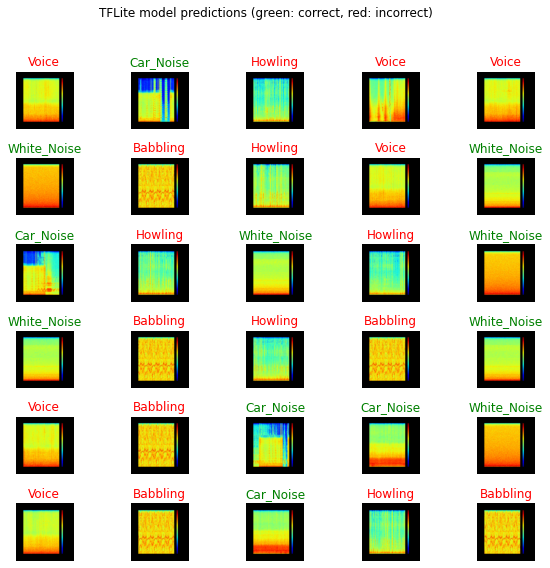

In [ ]:
# Print images batch and labels predictions for TFLite Model

tflite_predicted_ids = np.argmax(tflite_model_predictions, axis=-1)
tflite_predicted_labels = dataset_labels[tflite_predicted_ids]
tflite_label_id = np.argmax(val_label_batch, axis=-1)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if tflite_predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(tflite_predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("TFLite model predictions (green: correct, red: incorrect)")

In [ ]:
import time # time 라이브러리 import
start = time.time() # 시작
 
time.sleep(1) # 측정하고자 하는 코드 부분
 
print(f"{time.time()-start:.4f} sec") # 종료와 함께 수행시간 출력

1.0014 sec


In [ ]:
# Print images batch and labels predictions for TFLite Model

# TF 모델 예측

tflite_predicted_ids = np.argmax(tflite_model_predictions, axis=-1)
tflite_predicted_labels = dataset_labels[tflite_predicted_ids]
tflite_label_id = np.argmax(val_label_batch, axis=-1)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])



color = "green" if tflite_predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(tflite_predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("TFLite model predictions (green: correct, red: incorrect)")

## 이미지가 대부분 car_noise가 나오는 이유가 무엇일까
## 인식을 잘 못 하는 거 같음 왜 인식을 못하는지 해결해야할듯함
## 색이 들어가면 예측을 잘 못 하는 거 같음

IndentationError: ignored

In [ ]:
len(tflite_predicted_labels)

32

In [ ]:
# Print images batch and labels predictions for TFLite Model

# TF 모델 예측

tflite_predicted_ids = np.argmax(tflite_model_predictions, axis=-1)
tflite_predicted_labels = dataset_labels[tflite_predicted_ids]
tflite_label_id = np.argmax(val_label_batch, axis=-1)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(5000):
  # 총 개수가 분모로 가고 분자에는 green이 오는 개수
  correct = 0
  if tflite_predicted_ids[n] == true_label_ids[n]:
    color = "green"
    correct += 1
  else:
    color = "red"

print(correct / len(tflite_predicted_labels))



 # color = "green" if tflite_predicted_ids[n] == true_label_ids[n] else "red"
plt.title(tflite_predicted_labels[n].title(), color=color)
plt.axis('off')
_ = plt.suptitle("TFLite model predictions (green: correct, red: incorrect)")

## 이미지가 대부분 car_noise가 나오는 이유가 무엇일까
## 인식을 잘 못 하는 거 같음 왜 인식을 못하는지 해결해야할듯함
## 색이 들어가면 예측을 잘 못 하는 거 같음

IndexError: ignored

<Figure size 720x648 with 0 Axes>

In [ ]:
final_loss, final_accuracy = tflite_interpreter.evaluate(feature_test, label_test)

AttributeError: ignored

# Print images batch and labels predictions for TFLite Model

tflite_q_predicted_ids = np.argmax(tflite_q_model_predictions, axis=-1)
tflite_q_predicted_labels = dataset_labels[tflite_q_predicted_ids]
tflite_q_label_id = np.argmax(val_label_batch, axis=-1)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if tflite_q_predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(tflite_q_predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Quantized TFLite model predictions (green: correct, red: incorrect)")

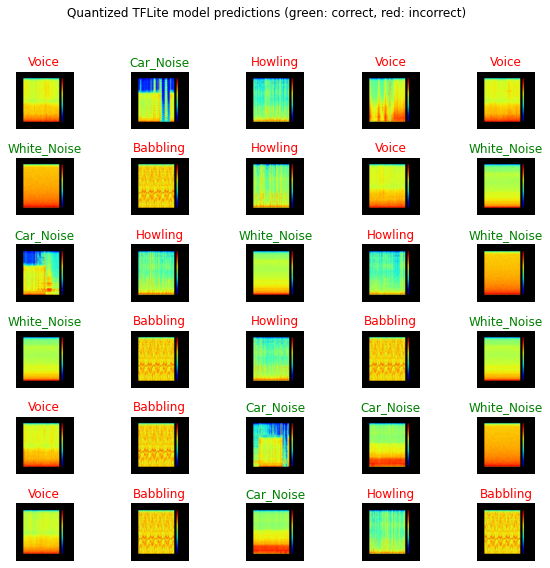

In [ ]:
# Print images batch and labels predictions for TFLite Model

# 양자화된 TF 모델 예측

tflite_q_predicted_ids = np.argmax(tflite_q_model_predictions, axis=-1)
tflite_q_predicted_labels = dataset_labels[tflite_q_predicted_ids]
tflite_q_label_id = np.argmax(val_label_batch, axis=-1)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if tflite_q_predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(tflite_q_predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Quantized TFLite model predictions (green: correct, red: incorrect)")

In [ ]:
import time # time 라이브러리 import
start = time.time() # 시작
 
time.sleep(1) # 측정하고자 하는 코드 부분
 
print(f"{time.time()-start:.4f} sec") # 종료와 함께 수행시간 출력

1.0023 sec


## Export image validation batch

Export validation batch so it can be tested client side. Below we create compressed file containing all images named with the convention:

`n{}_true{}_pred{}.jpg`

where the first number is index, the second - true label index, the third - value predicted by TFLite moder generated in this notebook. Example file will look similar to this: `n0_true1_pred1.jpg`.

All images then will be put into client side testing code (res/assets in Android tests). Integration tests will run inference process on each image and then compare results with the ones saved in file names.

from PIL import Image

In [ ]:
from PIL import Image

VAL_BATCH_DIR = "validation_batch"

In [ ]:
VAL_BATCH_DIR = "validation_batch"

!mkdir {VAL_BATCH_DIR}

In [ ]:
!mkdir {VAL_BATCH_DIR}

# Export batch to *.jpg files with specific naming convention.
# Make sure they are exported in the full quality, otherwise the inference
# process will return different results. 

for n in range(32):
  filename = "n{:0.0f}_true{:0.0f}_pred{:0.0f}.jpg".format(
      n,
      true_label_ids[n],
      tflite_model_pred_simplified[n][0]
  )
  img_arr = np.copy(val_image_batch[n])
  img_arr *= 255
  img_arr = img_arr.astype("uint8")
  img11 = Image.fromarray(img_arr, 'RGB')
  img11.save("{}/{}".format(VAL_BATCH_DIR, filename), "JPEG", quality=100)

In [ ]:
# Export batch to *.jpg files with specific naming convention.
# Make sure they are exported in the full quality, otherwise the inference
# process will return different results. 

for n in range(32):
  filename = "n{:0.0f}_true{:0.0f}_pred{:0.0f}.jpg".format(
      n,
      true_label_ids[n],
      tflite_model_pred_simplified[n][0]
  )
  img_arr = np.copy(val_image_batch[n])
  img_arr *= 255
  img_arr = img_arr.astype("uint8")
  img11 = Image.fromarray(img_arr, 'RGB')
  img11.save("{}/{}".format(VAL_BATCH_DIR, filename), "JPEG", quality=100)

!tar -zcvf {VAL_BATCH_DIR}.tar.gz {VAL_BATCH_DIR}

In [ ]:
!tar -zcvf {VAL_BATCH_DIR}.tar.gz {VAL_BATCH_DIR}

File `validation_batch.tar.gz` is ready to be downloaded, unpacked and put into client-side testing code.